In [4]:
from matplotlib import pyplot
import matplotlib
import pandas
from CO2_data_collector import CO2DataCollector
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import CO2_pre_processing as pre
from pylab import rcParams
from fbprophet.diagnostics import cross_validation

# Collect the data
In this section we show how to collect the emissions data for a given time period

In [3]:
collector = CO2DataCollector()

In [4]:
# Collects the data between two boundaries dates
collector.collect_data('2017-01-01', '2020-01-01')

In [5]:
# Generates a CSV file with the collected data
collector.generate_csv('Emissions_2018-2020.csv')

# Data Cleaning
In this section we will perform some data cleaning since there are some corrupted data
that needs to be cleaned to convert the Fecha's column from string to a datetime object

In [2]:
dataset = pandas.read_csv('Emissions_2018-2020.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157680 entries, 0 to 157679
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  157680 non-null  int64  
 1   Fecha       157680 non-null  object 
 2   Emisiones   157680 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ MB


Is there a problem with the data, on certain dates on the interval from 02 to 03, where there are corrupted hours like the following ones:
- 2019-10-27 2A:00
- 2019-10-27 2A:10
- 2019-10-27 2A:20
- 2019-10-27 2A:30
- 2019-10-27 2A:40
- 2019-10-27 2A:50
- 2019-10-27 2B:00
- 2019-10-27 2B:10
- 2019-10-27 2B:20
- 2019-10-27 2B:30
- 2019-10-27 2B:40
- 2019-10-27 2B:50

**Solution:**
- Drop rows which contain the letter 'B' in the Fecha's column
- In the rows where the date contains the characters 2A, replace these with 02

In [4]:
dataset.head()

,Unnamed: 0,Fecha,Emisiones
0,0,2016-12-31 21:00,9659.81
1,1,2016-12-31 21:10,9627.94
2,2,2016-12-31 22:30,9407.57
3,3,2016-12-31 21:20,9562.48
4,4,2016-12-31 21:30,9545.36


In [5]:
# Drop the Unnamed: 0 column
if 'Unnamed: 0' in dataset.columns:
    dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [6]:
# Replace dates with 2A by 02
dataset['Fecha'] = dataset['Fecha'].str.replace('2A', '02')
# Use the NOT simbol (~) to return the dataset without these rows
dataset = dataset[~dataset.Fecha.str.contains("2B")]

In [7]:
dataset.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00,9659.81
1,2016-12-31 21:10,9627.94
2,2016-12-31 22:30,9407.57
3,2016-12-31 21:20,9562.48
4,2016-12-31 21:30,9545.36
5,2016-12-31 21:50,9442.41
6,2016-12-31 22:10,9514.21
7,2016-12-31 21:40,9494.49
8,2016-12-31 22:20,9448.20
9,2016-12-31 22:00,9420.89


As we can see the dataset is unordered, so in order to sort it we must perform the following tasks:
- Convert the Datetime column 'Fecha' to a datetime object
- Set the Datetime column as the Index
- Sort the dataset by index

In [8]:
# Converts 'Fecha' to datetime object
dataset['Fecha'] = pandas.to_datetime(dataset['Fecha'])
# Sets the 'Fecha' column as index
dataset = dataset.set_index('Fecha')
# Sort the dataset by index
dataset = dataset.sort_index()

In [9]:
dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49


## Creation of alternative dataset
We will create an alternative dataset where the difference between timestamps is one hour, so the emissions will be grouped by hours

In [10]:
# Cretes the new dataset
dataset_freq_1hour = pre.create_dataset_timefreq_1hour(dataset)

In [11]:
dataset_freq_1hour.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97
5,2017-01-01 02:00:00,53940.48
6,2017-01-01 03:00:00,51843.22
7,2017-01-01 04:00:00,50390.88
8,2017-01-01 05:00:00,49331.71
9,2017-01-01 06:00:00,48633.39


## CSV Creation
Now we will create two csv files to store the cleaned dataset. In the first dataset, the difference between timestamps is one hour, while in the second the difference is ten minutes

In [17]:
dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49


**Creates 1 hour difference CSV**

In [13]:
# Creates a new CSV with no data errors and ordered rows by date
dataset_freq_1hour.to_csv("2017-2020_Emissions_by_hour_Clean.csv", index=False)

**Creates 10 minutes difference CSV**

In [14]:
# Creates a new CSV with no data errors and ordered rows by date
dataset.to_csv("2017-2020_Emissions_by_10_minutes_Clean.csv")

# Data Analysis

In [14]:
# Read both csv files
dataset_by_10_minutes = pandas.read_csv('2017-2020_Emissions_by_10_minutes_Clean.csv')
dataset_by_hour = pandas.read_csv('2017-2020_Emissions_by_hour_Clean.csv')

CSV files cannot cannot save datetime objects and saves the rows unordered, so each time we read a CSV file, we must
to perform the following tasks:
- Convert 'Fecha' column to datetime object
- Set 'Fecha' column as the new index
- Sort the dataset by DateTime Index

In [15]:
# This function perform the tasks above
dataset_by_10_minutes = pre.prepare_timeseries_dataset(dataset_by_10_minutes, 0)
dataset_by_hour = pre.prepare_timeseries_dataset(dataset_by_hour, 0)

In [16]:
dataset_by_10_minutes.head(10)

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49
2016-12-31 21:50:00,9442.41
2016-12-31 22:00:00,9420.89
2016-12-31 22:10:00,9514.21
2016-12-31 22:20:00,9448.20


In [17]:
dataset_by_hour.head(10)

,Emisiones
Fecha,
2016-12-31 21:00:00,57332.49
2016-12-31 22:00:00,56671.33
2016-12-31 23:00:00,57666.70
2017-01-01 00:00:00,57684.04
2017-01-01 01:00:00,56670.97
2017-01-01 02:00:00,53940.48
2017-01-01 03:00:00,51843.22
2017-01-01 04:00:00,50390.88
2017-01-01 05:00:00,49331.71


## Resample the dataset
In this section we will try to resample the dataset in order to obtain the mean of emissions for each month and decompose it to analyze
the trend and seasonality

In [18]:
dataset_by_hour.index

DatetimeIndex(['2016-12-31 21:00:00', '2016-12-31 22:00:00',
               '2016-12-31 23:00:00', '2017-01-01 00:00:00',
               '2017-01-01 01:00:00', '2017-01-01 02:00:00',
               '2017-01-01 03:00:00', '2017-01-01 04:00:00',
               '2017-01-01 05:00:00', '2017-01-01 06:00:00',
               ...
               '2019-12-31 11:00:00', '2019-12-31 12:00:00',
               '2019-12-31 13:00:00', '2019-12-31 14:00:00',
               '2019-12-31 15:00:00', '2019-12-31 16:00:00',
               '2019-12-31 17:00:00', '2019-12-31 18:00:00',
               '2019-12-31 19:00:00', '2019-12-31 20:00:00'],
              dtype='datetime64[ns]', name='Fecha', length=26276, freq=None)

If we look the frequency of our dataset, it is set to None, so we will have to infer it in order to resample the dataset

In [19]:
# Converts the dataset into a frequency of 1 hour, it doesn't change the data because it already have a frequency of 1 hour
dataset_by_hour = dataset_by_hour.asfreq('H')

Now we will try to resample the dataset to a monthly frequency and the mean of emissions

In [22]:
dataset_by_month = dataset_by_hour['Emisiones'].resample('MS').mean()

In [23]:
dataset_by_month.head(10)

Fecha
2016-12-01    57223.506667
2017-01-01    61563.583347
2017-02-01    46414.701845
2017-03-01    29037.953513
2017-04-01    24765.413931
2017-05-01    38081.439140
2017-06-01    50720.670472
2017-07-01    49045.904637
2017-08-01    39786.750027
2017-09-01    40026.869500
Freq: MS, Name: Emisiones, dtype: float64

In [25]:
# Check if some missing values have been created because of resampling
dataset_by_month.isnull().sum()

0

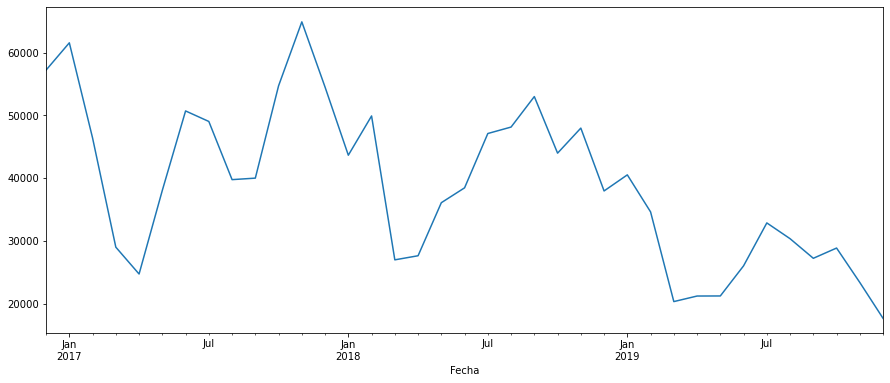

In [24]:
dataset_by_month.plot(figsize=(15, 6))
pyplot.show()

Looking the data we can form some hypotheses:
- It has a decreasing trend, maybe caused by some energy related politics which improve the use of renovables energies through the years
- It shows a seasonality pattern, from January to April emissions decrease greatly, then from April to December they increases to the peak but with some decreasing in September or October.

## Decompose the series

Now we will decompose the series into an additive or multiplicative series.

**Additive Series:**
Value = Base Level + Trend + Seasonality + Error

**Multiplicative Series:**
Value = Base Level * Trend * Seasonality * Error

It seems that the dataset is a multiplicative series because of it seems to be non-linear, the seasonality has different frequency and amplitude over time, we will plot both models and confirm this hypotheses

In [26]:
## If our dataset would not have a specific frequency, we would have to add the period parameter.
# Multiplicative Decomposition
result_mul = seasonal_decompose(dataset_by_month, model='multiplicative')
# Additive Decomposition
result_add = seasonal_decompose(dataset_by_month, model='additive')

In [33]:
# Set the figsize
rcParams['figure.figsize'] = 11, 11

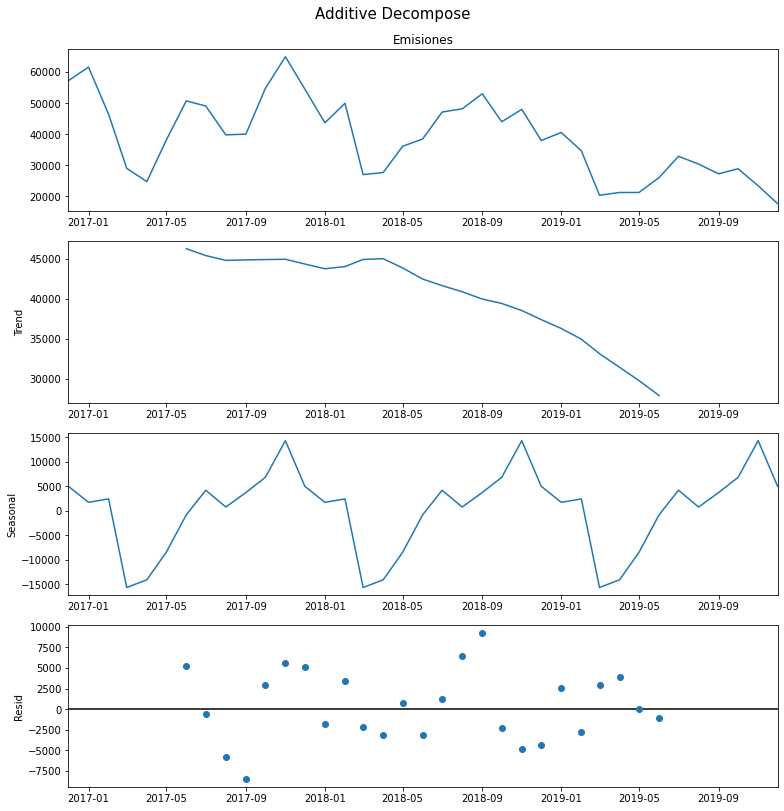

In [38]:
# Plot additive decomposition
result_add.plot().suptitle('Additive Decompose', fontsize=15, y=1.02)
pyplot.show()

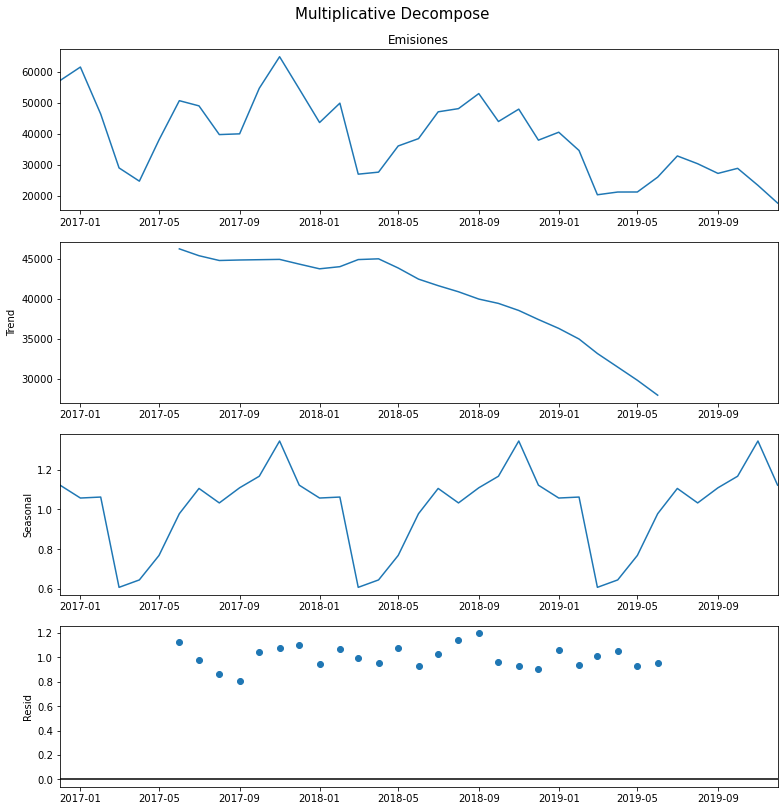

In [39]:
# Plot multiplicative decomposition
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15, y=1.02)
pyplot.show()

# Prophet model

In [8]:
prophet = Prophet()

In [9]:
prophet_dataset = dataset_by_hour
prophet_dataset = prophet_dataset.reset_index()
prophet_dataset = prophet_dataset.rename(columns={"Fecha": "ds", "Emisiones": "y"})

In [10]:
prophet_dataset.head()

,ds,y
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97


In [11]:
prophet.fit(prophet_dataset)

In [12]:
future_dates = prophet.make_future_dataframe(periods=48, freq='H')
future_dates.tail()

,ds
26323,2020-01-02 16:00:00
26324,2020-01-02 17:00:00
26325,2020-01-02 18:00:00
26326,2020-01-02 19:00:00
26327,2020-01-02 20:00:00


In [13]:
forecast = prophet.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
26323,2020-01-02 16:00:00,12963.181751,2847.486973,22541.220661
26324,2020-01-02 17:00:00,12751.945661,2398.346761,23405.123953
26325,2020-01-02 18:00:00,13408.120615,1975.927181,23957.652983
26326,2020-01-02 19:00:00,14844.651491,4626.934735,26216.821468
26327,2020-01-02 20:00:00,16213.343426,5398.964856,26624.815234


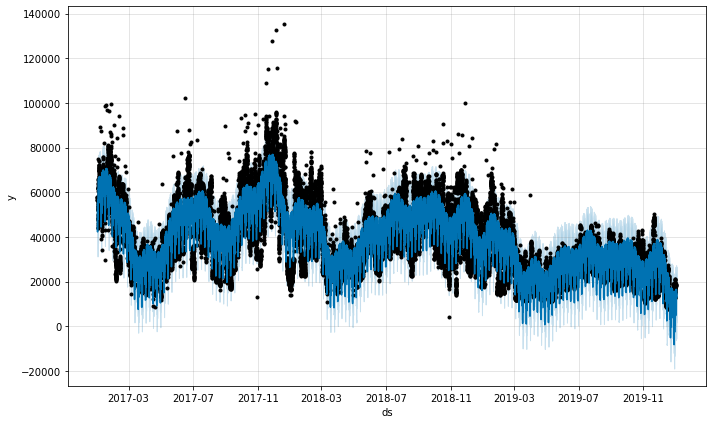

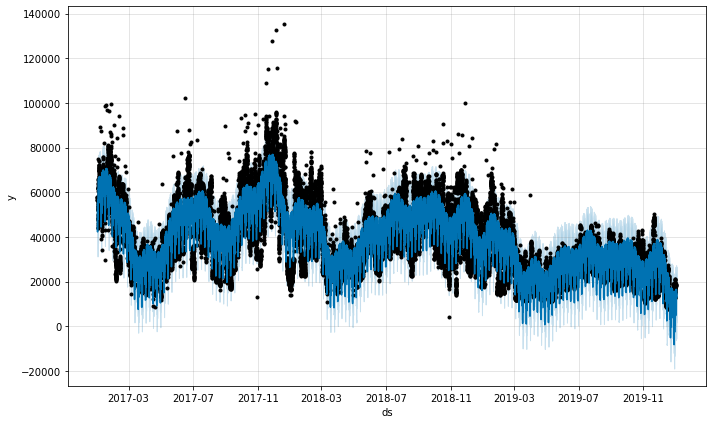

In [14]:
prophet.plot(forecast, uncertainty=True)

In [16]:
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '48 hours')
df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-01-03 20:00:00 and 2019-12-29 20:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-03 21:00:00,38349.491016,26461.208478,49522.461523,45745.42,2019-01-03 20:00:00
1,2019-01-03 22:00:00,36792.657942,24683.924947,47754.324041,43655.55,2019-01-03 20:00:00
2,2019-01-03 23:00:00,33767.155843,23526.567247,44847.060722,42590.40,2019-01-03 20:00:00
3,2019-01-04 00:00:00,30416.995516,19835.078600,41772.185344,37325.86,2019-01-03 20:00:00
4,2019-01-04 01:00:00,27767.336607,16298.972872,39331.037769,33996.87,2019-01-03 20:00:00


In [17]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,05:00:00,1.066702e+08,10328.128066,9139.788623,0.445196,0.191708,0.666667
1,06:00:00,1.161867e+08,10778.993056,9510.825203,0.494244,0.202743,0.666667
2,07:00:00,1.210126e+08,11000.574113,9571.785341,0.532815,0.202270,0.666667
3,08:00:00,1.213863e+08,11017.544926,9353.312352,0.549884,0.202270,0.666667
4,09:00:00,1.225223e+08,11068.977880,9190.657189,0.544528,0.193358,0.666667


# ARIMA Model
In this section we will implement an ARIMA model to see if it performs better than Prophet

In [5]:
import itertools
import statsmodels.api as sm
pyplot.style.use('fivethirtyeight')

In [6]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


## Grid Search
We will use Grid Search to find the best (p, d, q) values for the series. The model will return the AIC measures, in this case we are interested in the parameters which output the lowest AIC

In [20]:
arima_dataset = dataset_by_hour

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(arima_dataset, order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False, enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:633414.5534041435
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:617922.4902390288
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:553543.369327063
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:547844.6974175044
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:553239.0489663963
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:548011.2324527923
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:543522.3537183173
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:537873.8818250234
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:614710.5225602345
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:610406.5693869421
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:540071.4191781168
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:535526.467124832
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:537415.3385394595
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:607220.9762419576
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:534370.168653645
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:533219.5452572261
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:508177.5135144641
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:507897.78326784447
ARIMA(0, 1, 

D:\Anaconda\envs\CO2_Project_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:501736.4989340274
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:506846.8673140489
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:501595.20355398674
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:506049.3003517866
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:507419.4867774888


## Fitting model
Best paremeter selection is 

ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:499769.9674980558

In [21]:
mod = sm.tsa.statespace.SARIMAX(arima_dataset, order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3077      0.002   -157.820      0.000      -0.312      -0.304
ar.S.L12      -0.2151      0.005    -43.282      0.000      -0.225      -0.205
ma.S.L12      -0.9580      0.001  -1005.360      0.000      -0.960      -0.956
sigma2      1.077e+07   2.74e+04    392.675      0.000    1.07e+07    1.08e+07


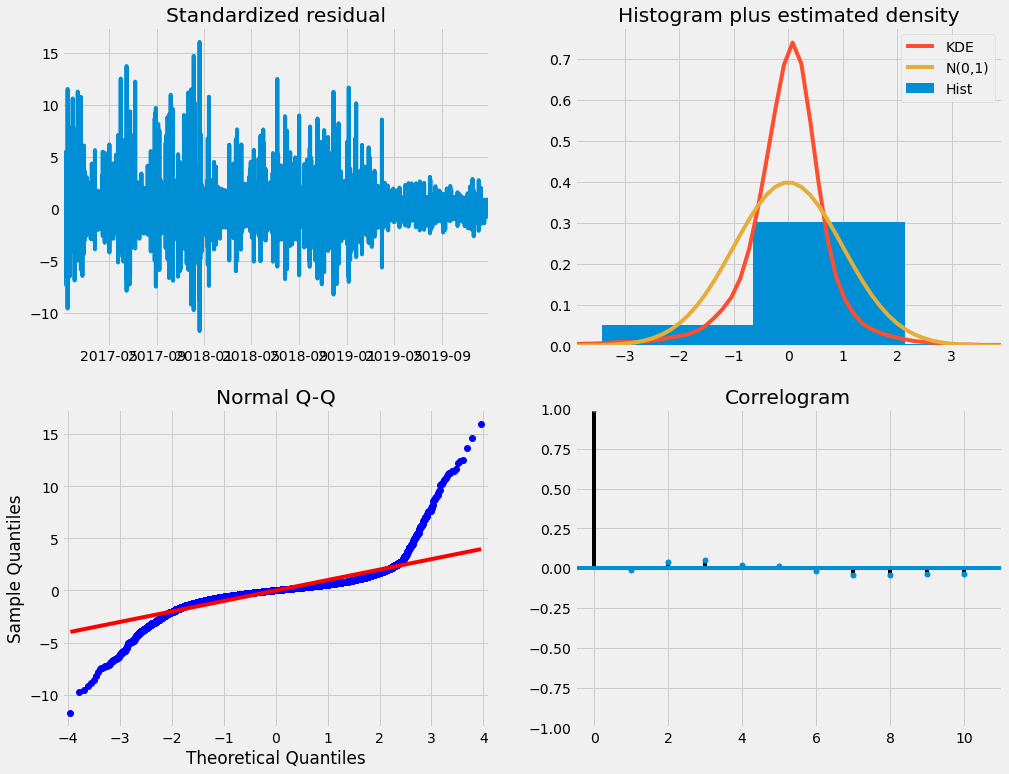

In [23]:
results.plot_diagnostics(figsize=(15, 12))
pyplot.show()

## Validating forecast
We will produce a forecast of a small period in order to validate it and apply the forecast in larger predictions